# Introduction 

In this notebook, we will explain how the hardsweep functionality works in pysweep. We will make a dummpy instrument called "Gaussian2D" to which we can send set points as arrays. The detector will subsequently send back an array representing measured values: `f(x, y) = N(x-locx, y-locy)`. Here `N(x, y) = ampl * exp(-(sx*x**2+sy*y**2+sxy*x*y))` is a 2D Gaussian. 

We will show how to perform a hardware sweep and how we can nest a hardware sweep in a software controlled sweep. To demonstrate the latter, we will sweep the value of `locx` in software. For each set point of `locx` we will get a measurement represening an 2D image. 

## Imports 

In [1]:
import numpy as np
import itertools
import matplotlib.pyplot as plt
from functools import partial

from qcodes import Instrument
from qcodes.dataset.data_export import get_data_by_id

from pytopo.sweep import sweep, do_experiment, hardsweep

## Setting up a dummy instrument

In [2]:
class Gaussian2D(Instrument): 
    def __init__(self, name, loc, sig, ampl): 
        super().__init__(name)
        
        self._loc = np.array(loc)
        self._ampl = ampl
        
        if np.atleast_2d(sig).shape == (1, 1): 
            sig = sig * np.identity(2)
        self._sig = sig 
        
        self.add_parameter(
            "locx",
            set_cmd=lambda value: partial(self.set_loc, locx=value)()
        )
        
        self.add_parameter(
            "locy",
            set_cmd=lambda value: partial(self.set_loc, locy=value)()
        )
    
    def send(self, setpoints): 
        self._setpoints = setpoints 
    
    def set_loc(self, locx=None, locy=None):
        locx = locx or self._loc[0]
        locy = locy or self._loc[1]
        self._loc = np.array([locx, locy])
    
    def __call__(self): 
        r = self._setpoints - self._loc[:, None]
        sig_inv = np.linalg.inv(self._sig)
        rscaled = np.matmul(sig_inv, r)
        dist = np.einsum("ij,ij->j", r, rscaled)
        return self._ampl * np.exp(-dist)

## Make a detector

In [3]:
loc = [0.5, -0.3]  # The location of the Gaussian blob 
sig = np.array([[1.0, 0.9], [0.9, 3.0]])
ampl = 1

gaussian2d = Gaussian2D("gaussian", loc, sig, ampl)

## Test if the detector works 

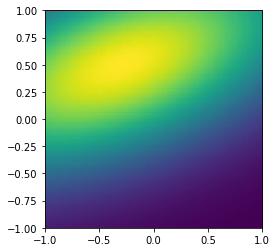

In [4]:
def sample_points():
    x = np.linspace(-1, 1, 100)
    y = np.linspace(-1, 1, 100)

    xx, yy = zip(*itertools.product(x, y))
    xy = np.vstack([xx, yy])
    return xy

xy = sample_points()
gaussian2d.send(xy)  # Send the set points. In a real hardware sweep, this can be a different instrument
meas = gaussian2d()  # Make the detector measure at the setpoints 

# Construct an image to see if we were succesfull. We should see an rotated and elongated gaussian blurr. 
img = meas.reshape((100, 100))

plt.imshow(img, extent=[-1, 1, -1, 1], interpolation="nearest", origin="lower")
plt.show()

## setting up the hardsweep 

We make a hardsweep by using the `hardsweep` decorator in the `pytopo.sweep` module. *In this example*, the number of independent parameters `ind` is two (`x` and `y`) and the numbers of measurement parameters is one (`i`). The decorator parameters `ind` and `dep` are arrays of tuples `(name, unit)`. 

The decorator does not place any restrictions on the number and type of arguments of the decorated function; this can be anything the user desires. However, the decorated function *must* return two parameters; the set points and measurements, both of which are ndarrays. The first dimension of the set points array contains the number of independent parameters. This must match the number of `ind` parameters given in the decorator, else an exception is raised. In the example, `setpoints` is an 2-by-N array since we have two independent parameters `x` and `y`. `N` is the number of set points. 

Likewise the first dimension of the measurements array contains the number of measurements *per set point*. In this example, we have one measurement `f(x, y)` per set point, where `f` is the previously mentioned 2D Gaussian. This is reflected by the fact that the number of dependent parameter registered in the decorator is one: `i`. The number of measurements `N` must match the number of set points. 

In [5]:
@hardsweep(ind=[("x", "V"), ("y", "V")], dep=[("i", "A")])
def hardware_measurement(setpoints, detector): 
    """
    Use the detector to measure at given set points. Notice that 
    we do not literally iterate over the set points, rather, we let 
    the hardware take care of this.
    
    Returns: 
        spoint_values (ndarray): 2-by-n array of setpoints
        measurements (ndarray): 1-by-n array of measurements
    """
    spoint_values = setpoints()
    detector.send(spoint_values)
    measurements = detector()
    
    return spoint_values, measurements

## Perform the hardware sweep

In [6]:
data = do_experiment(
    "hardweep/1", 
    hardware_measurement(sample_points, gaussian2d)
)

Starting experimental run with id: 8


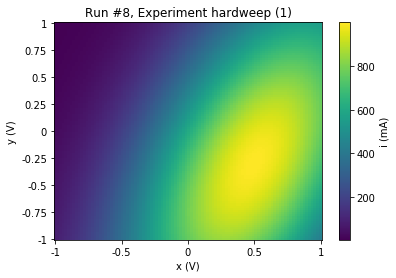

In [7]:
data.plot()

## Combining a hardware and software sweep 

We will now sweep the location of the Gaussin blob along the x-axis and for each set point, we will perform a hardware measurement 

In [8]:
sweep_object = sweep(gaussian2d.locx, np.linspace(-0.8, 0.8, 9))(
    hardware_measurement(sample_points, gaussian2d)
)

In [9]:
data = do_experiment(
    "hardweep/2",
    sweep_object
)

Starting experimental run with id: 9


## Plot all the hardware measurements 

In [10]:
data_dict = get_data_by_id(data.run_id)

In [11]:
print("parameter name (units) - shape of array")
print("---------------------------------------")
for axis_data in data_dict[0]:
    print(f"{axis_data['name']} ({axis_data['unit']}) - {axis_data['data'].shape} array")

parameter name (units) - shape of array
---------------------------------------
gaussian_locx () - (90000,) array
x (V) - (90000,) array
y (V) - (90000,) array
i (A) - (90000,) array


In [12]:
unique_locx = np.unique(data_dict[0][0]['data'])

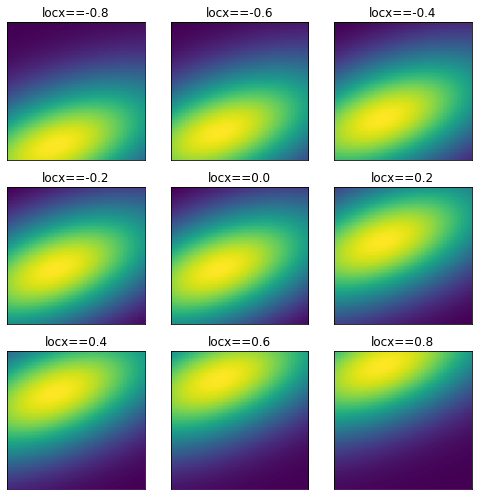

In [13]:
f, axes = plt.subplots(3, 3, figsize=(7, 7))

for locx, ax in zip(unique_locx, axes.ravel()):
    imgdata1 = np.array(data_dict[0][3]['data'][data_dict[0][0]['data'] == locx]).reshape(100, 100)
    ax.imshow(imgdata1, 
              extent=[-1, 1, -1, 1], 
              interpolation="nearest", 
              origin="lower")
    ax.set_title(f"locx=={locx}")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

f.tight_layout()